In [76]:
#initialise

import extractor
extractor.main()
fps = extractor.fps
resolution = extractor.resolution





FPS: 30.0
Resolution: 638x360
Audio extracted to output_data/audio.mp3
Extracted 452 frames.
Feature data has been collected!
Writing data to csv
Features saved to output_data/output_features.csv
Extraction completed!


In [77]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  




In [78]:
# config:
unbiased = True # Should data be shuffled before training. Biased data is more accurate with reconstruction of the original video.
feature_threshold = 0.3 # between 0 and 1, how much should the data correlate to the target variable? 1 is 1 to 1 and 0 is not at all

In [79]:
import pydub

df = pd.read_csv('output_data/output_features.csv')
df['frame_index'] = df.index
df['normalized_index']=df['frame_index']/len(df)

audio_full = pydub.AudioSegment.from_mp3('output_data/audio.mp3')

slice_paths = []

for i in range(len(df['timestamp'])):
    frame_start = df['timestamp'][i]
    if i >= len(df['timestamp'])-1:
        frame_end = len(audio_full)
    else:
        frame_end = df['timestamp'][(i+1)]
    slice:pydub.AudioSegment = audio_full[frame_start:frame_end]
    slice_path = f'output_slices/audio_slice_{frame_start*0.001}_{i}.wav'
    slice.export(slice_path, format='wav')
    slice_paths.append(slice_path)

    




df['audio_slice_path'] = slice_paths
if unbiased:
    df = df.sample(frac=1.0,random_state=42).reset_index(drop=True)
print(df[['frame_filename','frame_index','normalized_index','audio_slice_path']].head())

                           frame_filename  frame_index  normalized_index  \
0   output_frames/frame_299_time_9966.jpg          299          0.661504   
1    output_frames/frame_39_time_1300.jpg           39          0.086283   
2  output_frames/frame_336_time_11200.jpg          336          0.743363   
3  output_frames/frame_332_time_11066.jpg          332          0.734513   
4   output_frames/frame_153_time_5100.jpg          153          0.338496   

                                    audio_slice_path  
0  output_slices/audio_slice_9.966000000000001_29...  
1               output_slices/audio_slice_1.3_39.wav  
2  output_slices/audio_slice_11.200000000000001_3...  
3           output_slices/audio_slice_11.066_332.wav  
4  output_slices/audio_slice_5.1000000000000005_1...  


In [80]:
# Check shape
print("DataFrame shape:", df.shape)

# Check first few rows
print(df.head())



# Check if you accidentally only have one row
if df.shape[0] <= 1:
    print("Warning: Only 1 row detected!")

#df = df[df != 0] # remove redundant parameters
# Check for missing rows or NaNs
df = df.loc[:,(df != 0).any(axis=0)]
print(df.isnull().sum())



DataFrame shape: (452, 1517)
   timestamp                          frame_filename  hist_bin_0  hist_bin_1  \
0       9966   output_frames/frame_299_time_9966.jpg    0.039659    0.254383   
1       1300    output_frames/frame_39_time_1300.jpg    0.986506    0.072129   
2      11200  output_frames/frame_336_time_11200.jpg    0.198156    0.079534   
3      11066  output_frames/frame_332_time_11066.jpg    0.312327    0.138174   
4       5100   output_frames/frame_153_time_5100.jpg    0.987780    0.072993   

   hist_bin_2  hist_bin_3  hist_bin_4  hist_bin_5  hist_bin_6  hist_bin_7  \
0    0.000542    0.000102    0.000023         0.0         0.0         0.0   
1    0.018631    0.006138    0.000000         0.0         0.0         0.0   
2    0.104271    0.079081    0.000036         0.0         0.0         0.0   
3    0.072287    0.115425    0.000273         0.0         0.0         0.0   
4    0.012026    0.007257    0.000000         0.0         0.0         0.0   

   ...  edge_993  edge_994 

In [81]:
#Correlation test
numerical_df = df.select_dtypes(include=['float64','int64'])



corr_matrix = numerical_df.corr()
normalized_index_corr = corr_matrix['normalized_index'].sort_values(ascending=False)
normalized_index_corr = normalized_index_corr.drop(['normalized_index','timestamp','frame_index'])
print(normalized_index_corr)

hist_bin_144    0.733688
edge_938        0.729903
edge_940        0.729903
edge_941        0.729903
edge_939        0.729903
                  ...   
hist_bin_81    -0.740889
hist_bin_154   -0.761627
hist_bin_0     -0.851132
hist_bin_8     -0.856122
hist_bin_72    -0.863984
Name: normalized_index, Length: 1080, dtype: float64


In [82]:

X = df.drop(['timestamp','frame_filename','frame_index','normalized_index','audio_slice_path'], axis=1)
y = df['normalized_index']

In [83]:
# get strong features
strong_features = normalized_index_corr[abs(normalized_index_corr) > feature_threshold].index.to_list()
print(strong_features)
X = X[strong_features]

['hist_bin_144', 'edge_938', 'edge_940', 'edge_941', 'edge_939', 'edge_942', 'edge_904', 'edge_907', 'edge_306', 'edge_908', 'edge_906', 'edge_937', 'edge_379', 'edge_898', 'edge_897', 'edge_901', 'edge_913', 'edge_899', 'edge_903', 'edge_909', 'edge_902', 'edge_917', 'edge_895', 'hist_bin_155', 'hist_bin_156', 'edge_912', 'edge_273', 'edge_900', 'edge_257', 'hist_bin_209', 'hist_bin_148', 'hist_bin_147', 'edge_916', 'edge_914', 'hist_bin_75', 'edge_911', 'edge_920', 'edge_918', 'hist_bin_289', 'edge_921', 'edge_919', 'edge_272', 'hist_bin_65', 'hist_bin_220', 'hist_bin_362', 'edge_922', 'hist_bin_228', 'edge_923', 'hist_bin_221', 'edge_929', 'hist_bin_212', 'hist_bin_138', 'hist_bin_69', 'hist_bin_139', 'edge_926', 'edge_936', 'edge_928', 'hist_bin_146', 'hist_bin_157', 'hist_bin_361', 'hist_bin_80', 'hist_bin_67', 'edge_930', 'edge_931', 'edge_927', 'hist_bin_293', 'hist_bin_213', 'hist_bin_288', 'hist_bin_280', 'edge_932', 'hist_bin_66', 'hist_bin_136', 'hist_bin_140', 'hist_bin_82'

In [84]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [85]:
y_pred = model.predict(X_test)

In [86]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 0.0004
R2 Score: 0.9955


In [87]:
df['predicted_normalized_index'] = model.predict(X)

# sort by predicted order
df_sorted = df.sort_values(by='predicted_normalized_index')

print(df_sorted[['frame_filename','predicted_normalized_index']].head(10))


                          frame_filename  predicted_normalized_index
215    output_frames/frame_2_time_66.jpg                    0.008695
381    output_frames/frame_1_time_33.jpg                    0.009558
120   output_frames/frame_3_time_100.jpg                    0.009602
110   output_frames/frame_5_time_166.jpg                    0.012323
189   output_frames/frame_6_time_200.jpg                    0.014934
135   output_frames/frame_7_time_233.jpg                    0.016969
28    output_frames/frame_9_time_300.jpg                    0.020708
347   output_frames/frame_8_time_266.jpg                    0.021173
56   output_frames/frame_11_time_366.jpg                    0.021549
61      output_frames/frame_0_time_0.jpg                    0.021726


In [88]:
import cv2

output_video = cv2.VideoWriter('output_data/reconstructed.avi',
                               cv2.VideoWriter_fourcc(*'XVID'),
                               fps,
                               resolution)  


for _, row in df_sorted.iterrows():
    frame = cv2.imread(row['frame_filename'])
    output_video.write(frame)

output_video.release()
print("Reconstructed Video Saved!!")

Reconstructed Video Saved!!


In [89]:
final_audio:pydub.AudioSegment = pydub.AudioSegment.empty()
for s in df_sorted['audio_slice_path']:
    sorted_slice = pydub.AudioSegment.from_wav(s)
    final_audio = final_audio.append(sorted_slice, crossfade=0)
final_audio.export('output_data/final_audio.mp3')

<_io.BufferedRandom name='output_data/final_audio.mp3'>

In [90]:
import subprocess

def combine_audio_video(reconstructed_video, audio_file, output_video):
    command = ['ffmpeg', '-i', reconstructed_video, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', output_video, '-y']
    subprocess.run(command, check=True)
    print(f"Final video saved to {output_video}")

combine_audio_video('output_data/reconstructed.avi', 'output_data/final_audio.mp3','output_data/final_output.mp4')

Final video saved to output_data/final_output.mp4


In [91]:
print(df_sorted['audio_slice_path'])
df.to_csv('output_data/final_output_data.csv')


215                output_slices/audio_slice_0.066_2.wav
381                output_slices/audio_slice_0.033_1.wav
120                  output_slices/audio_slice_0.1_3.wav
110                output_slices/audio_slice_0.166_5.wav
189                  output_slices/audio_slice_0.2_6.wav
                             ...                        
86                output_slices/audio_slice_14.9_447.wav
443             output_slices/audio_slice_15.033_451.wav
414             output_slices/audio_slice_14.933_448.wav
286    output_slices/audio_slice_14.966000000000001_4...
268               output_slices/audio_slice_15.0_450.wav
Name: audio_slice_path, Length: 452, dtype: object


In [92]:
from joblib import dump
dump(model, 'model/video_reconstructor_model.joblib')

used_columns = X.columns.tolist()

# prevent misalignment of columns for other video inputs
import json
with open('output_data/used_feature_columns.json', 'w') as f:
    json.dump(used_columns, f)

['hist_bin_144', 'edge_938', 'edge_940', 'edge_941', 'edge_939', 'edge_942', 'edge_904', 'edge_907', 'edge_306', 'edge_908', 'edge_906', 'edge_937', 'edge_379', 'edge_898', 'edge_897', 'edge_901', 'edge_913', 'edge_899', 'edge_903', 'edge_909', 'edge_902', 'edge_917', 'edge_895', 'hist_bin_155', 'hist_bin_156', 'edge_912', 'edge_273', 'edge_900', 'edge_257', 'hist_bin_209', 'hist_bin_148', 'hist_bin_147', 'edge_916', 'edge_914', 'hist_bin_75', 'edge_911', 'edge_920', 'edge_918', 'hist_bin_289', 'edge_921', 'edge_919', 'edge_272', 'hist_bin_65', 'hist_bin_220', 'hist_bin_362', 'edge_922', 'hist_bin_228', 'edge_923', 'hist_bin_221', 'edge_929', 'hist_bin_212', 'hist_bin_138', 'hist_bin_69', 'hist_bin_139', 'edge_926', 'edge_936', 'edge_928', 'hist_bin_146', 'hist_bin_157', 'hist_bin_361', 'hist_bin_80', 'hist_bin_67', 'edge_930', 'edge_931', 'edge_927', 'hist_bin_293', 'hist_bin_213', 'hist_bin_288', 'hist_bin_280', 'edge_932', 'hist_bin_66', 'hist_bin_136', 'hist_bin_140', 'hist_bin_82'

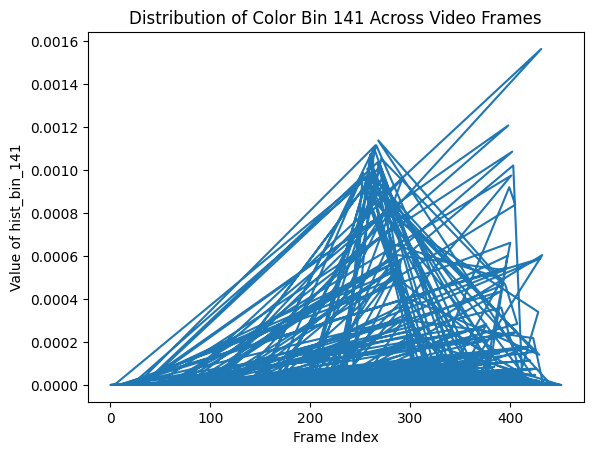

In [93]:
# debug

print(X.columns.to_list())

import matplotlib.pyplot as plt
plt.plot(df['frame_index'], df['hist_bin_141'])
plt.xlabel('Frame Index')
plt.ylabel('Value of hist_bin_141')
plt.title('Distribution of Color Bin 141 Across Video Frames')
plt.show()

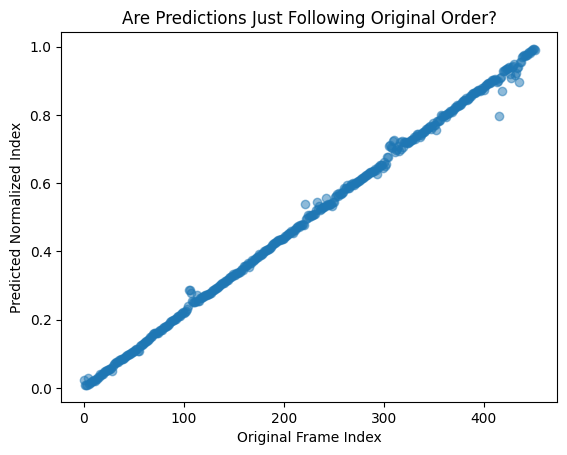

In [94]:
plt.scatter(df['frame_index'], df['predicted_normalized_index'], alpha=0.5)
plt.xlabel("Original Frame Index")
plt.ylabel("Predicted Normalized Index")
plt.title("Are Predictions Just Following Original Order?")
plt.show()
